<a href="https://colab.research.google.com/github/LeeSeungwon89/Deep-learning_Theory/blob/main/8-2%20%ED%95%A9%EC%84%B1%EA%B3%B1%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8-2 합성곱 신경망을 사용한 이미지 분류**

## **패션 MNIST 데이터 불러오기**

패션 MNIST 데이터를 준비하겠습니다. 다만 이전 챕터에서 수행했던 전처리 과정과 다른 부분이 있습니다. 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 `reshape()` 메서드나 `Flatten` 클래스를 사용하여 일렬로 펼쳤습니다. 그러나 합성곱 신경망에서는 2차원 이미지를 바로 사용하므로 일렬로 펼치는 작업을 수행할 필요가 없습니다. 다만 입력 이미지는 깊이 차원(채널)이 있어야 합니다. 흑백 이미지는 채널 차원이 없는 2차원 배열이지만 `Conv2D` 층을 사용하려면 마지막에 채널 차원을 추가해야 합니다. `reshape()` 메서드를 사용하면 전체 배열 차원을 그대로 유지하면서 차원만 추가할 수 있습니다.

데이터를 준비하겠습니다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# 기존 (48000, 28, 28) 3차원 배열을 (48000, 28, 28, 1) 4차원 배열로 차원을 바꿉니다.
# 데이터 스케일을 0 ~ 1 사이로 바꾸기 위해 255로 나눕니다.
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target,
                                                                      test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


## **합성곱 신경망 만들기**

`Sequential` 클래스의 인스턴스를 생성하여 처음 합성곱 층인 `Conv2D`를 추가하겠습니다.

In [2]:
model = keras.Sequential()
# 필터 32개, 커널 (3, 3), 렐루 함수, 세임 페딩을 지정합니다.
# 커널의 경우 (3, 3)처럼 가로세로 크기가 같으면 `3`을 지정해도 됩니다.
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(28, 28, 1)))

입력 차원을 `(28, 28)`이 아닌 `(28, 28, 1)`을 지정한 이유는 위 전처리 과정에서 기존 이미지를 4차원인 (48000, 28, 28, 1)로 변경했기 때문입니다.

풀링 층을 추가하겠습니다.

In [3]:
# 전형적인 풀링 크기인 (2, 2)를 지정합니다.
# `Conv2D` 클래스처럼 가로세로 크기가 같으므로 `2`를 지정해도 됩니다.
model.add(keras.layers.MaxPooling2D(2))

(28, 28) 이미지에 세임 패딩을 적용했으므로 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일합니다. 여기에 (2, 2) 풀링을 적용했으므로 특성 맵 크기는 절반으로 축소됩니다. 아울러 합성곱 층에서 필터 32개를 사용했으므로 특성 맵 깊이는 32입니다. 궁극적으로 특성 맵 크기는 (14, 14, 32)가 됩니다.

처음 합성곱-풀링 층 다음에 새로운 합성곱-풀링 층을 추가해 보겠습니다.

In [4]:
# 두 번째 층부터는 입력을 지정하지 않습니다. 
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

세임 패딩을 적용했으므로 입력의 가로세로 크기는 그대로입니다. 풀링 층에서 크기를 절반으로 줄이는 것입니다. 필터 64개를 사용했으므로 특성 맵 크기는 (7, 7, 64)가 됩니다.

특성 맵을 일렬로 펼치겠습니다. 유닛 10개를 가진 밀집 출력층에서 확률을 계산하기 때문입니다. 여기서는 특성 맵을 일렬로 펼치고 밀집 은닉층 하나를 추가해 보겠습니다. 

In [5]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
# 드롭아웃 층을 추가하여 은닉층의 과대적합을 방지합니다.
model.add(keras.layers.Dropout(0.4))
# 다중 분류이므로 소프트맥스 함수를 사용합니다.
model.add(keras.layers.Dense(10, activation='softmax'))

모델 구조를 확인해 보겠습니다.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

합성곱 층과 풀링 층이 적절하게 배치됐습니다. 처음 합성곱 층에서 32였던 깊이가 두 번째 합성곱 층에서 64로 두 배 증가하고, 28이었던 가로세로 크기는 절반으로 줄고 다시 절반으로 줍니다. 최종 특성 맵 크기는 (7, 7, 64)입니다.

모델 파라미터 개수는 처음 합성곱 층의 경우 필터는 32개, 크기는 (3, 3), 깊이는 1, 절편은 32개(필터 개수와 같음)이므로 총 320개(3 x 3 x 1 x 32 + 32)입니다. 두 번째 합성곱 층의 경우 필터는 64개, 크기는 (3, 3), 깊이는 32, 절편은 64개이므로 18,496개(3 x 3 x 32 x 64 + 64)입니다.

은닉층의 경우 `Flatten` 클래스로 특성 맵 (7, 7, 64)를 1차원으로 펼치면 (3146,)이 되고, 이를 유닛 100개와 연결하면 파라미터 개수는 313,700개(3,136 x 100 + 100)입니다. 출력층의 경우 유닛 10개와 연결하면 1010개(100 x 10 + 10)입니다.

층의 구성을 다른 방식으로 확인해 보겠습니다. 케라스의 `utils` 모듈이 가진 `plot_model()` 메서드는 층의 구성을 그림으로 표현합니다. 

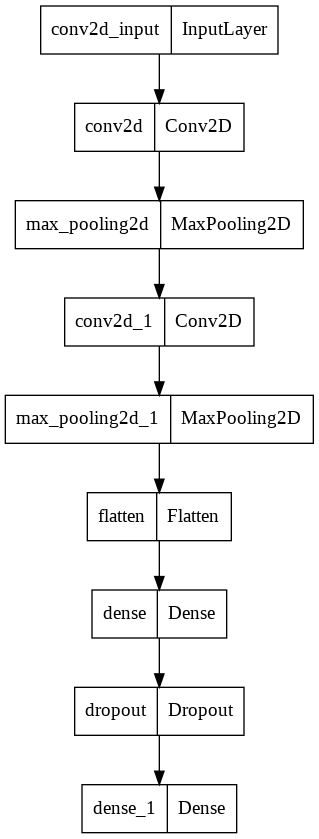

In [7]:
keras.utils.plot_model(model)



---

작업 중

---



## **모델 컴파일과 훈련**